In [1]:
%pip install pyspark

You should consider upgrading via the '/Users/michael/.pyenv/versions/3.10.5/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Lets download all the CSVs from `links.txt` which contain the visitor records throughout 2022

In [19]:
!mkdir data
!wget -c -q -i links.txt -P data

mkdir: data: File exists


In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
spark = SparkSession.builder.appName("whitehouse").getOrCreate()
spark

23/08/31 17:58:25 WARN Utils: Your hostname, Michaels-MacBook-Air-49.local resolves to a loopback address: 127.0.0.1; using 10.91.63.36 instead (on interface en0)
23/08/31 17:58:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/31 17:58:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/08/31 17:58:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [20]:
schema = StructType([
    StructField('Last Name', StringType(), True),
    StructField('First Name', StringType(), True),
    StructField('Middle Initial', StringType(), True),
    StructField('UIN', StringType(), True),
    StructField('BDGNBR', StringType(), True),
    StructField('Access Type', StringType(), True),
    StructField('TOA', StringType(), True),
    StructField('POA', StringType(), True),
    StructField('TOD', StringType(), True),
    StructField('POD', StringType(), True),
    StructField('Appointment Made Date', StringType(), True),
    StructField('Appointment Start Date', StringType(), True),
    StructField('Appointment End Date', StringType(), True),
    StructField('Appointment Cancel Date', StringType(), True),
    StructField('Total People', IntegerType(), True),
    StructField('Last Updated By', StringType(), True),
    StructField('POST', StringType(), True),
    StructField('Last Entry Date', StringType(), True),
    StructField('Terminal Suffix', StringType(), True),
    StructField('Visitee Last Name', StringType(), True),
    StructField('Visitee First Name', StringType(), True),
    StructField('Meeting Location', StringType(), True),
    StructField('Meeting Room', StringType(), True),
    StructField('Caller Last Name', StringType(), True),
    StructField('Caller First Name', StringType(), True),
    StructField('CALLER_ROOM', StringType(), True),
    StructField('RELEASEDATE', StringType(), True)
])

df = spark.read.csv("data/*.csv", header=True,
                    schema=schema, enforceSchema=True)


In [21]:
df.count()

583170

In [23]:
df.show()

+----------+-------------+--------------+------+------+-----------+-------------------+----+----+----+---------------------+----------------------+--------------------+-----------------------+------------+---------------+----+----------------+---------------+-----------------+------------------+----------------+-------------------+----------------+-----------------+-----------+-----------+
| Last Name|   First Name|Middle Initial|   UIN|BDGNBR|Access Type|                TOA| POA| TOD| POD|Appointment Made Date|Appointment Start Date|Appointment End Date|Appointment Cancel Date|Total People|Last Updated By|POST| Last Entry Date|Terminal Suffix|Visitee Last Name|Visitee First Name|Meeting Location|       Meeting Room|Caller Last Name|Caller First Name|CALLER_ROOM|RELEASEDATE|
+----------+-------------+--------------+------+------+-----------+-------------------+----+----+----+---------------------+----------------------+--------------------+-----------------------+------------+---------

In [24]:
timestamp_cols = ["Appointment Made Date", "Appointment Start Date", "Appointment End Date", "Appointment Cancel Date", "Last Entry Date"]
for ts_col in timestamp_cols:
    df = df.withColumn(ts_col, F.to_timestamp(ts_col, "M/d/yyyy H:mm"))

StructType([StructField('Last Name', StringType(), True), StructField('First Name', StringType(), True), StructField('Middle Initial', StringType(), True), StructField('UIN', StringType(), True), StructField('BDGNBR', StringType(), True), StructField('Access Type', StringType(), True), StructField('TOA', StringType(), True), StructField('POA', StringType(), True), StructField('TOD', StringType(), True), StructField('POD', StringType(), True), StructField('Appointment Made Date', TimestampType(), True), StructField('Appointment Start Date', TimestampType(), True), StructField('Appointment End Date', TimestampType(), True), StructField('Appointment Cancel Date', TimestampType(), True), StructField('Total People', IntegerType(), True), StructField('Last Updated By', StringType(), True), StructField('POST', StringType(), True), StructField('Last Entry Date', TimestampType(), True), StructField('Terminal Suffix', StringType(), True), StructField('Visitee Last Name', StringType(), True), Str

In [25]:
df = df.withColumn("TOA", F.to_timestamp("TOA", "MMM [ ]d yyyy [ ]h:mma"))

In [26]:
df.show()

+----------+-------------+--------------+------+------+-----------+-------------------+----+----+----+---------------------+----------------------+--------------------+-----------------------+------------+---------------+----+-------------------+---------------+-----------------+------------------+----------------+-------------------+----------------+-----------------+-----------+-----------+
| Last Name|   First Name|Middle Initial|   UIN|BDGNBR|Access Type|                TOA| POA| TOD| POD|Appointment Made Date|Appointment Start Date|Appointment End Date|Appointment Cancel Date|Total People|Last Updated By|POST|    Last Entry Date|Terminal Suffix|Visitee Last Name|Visitee First Name|Meeting Location|       Meeting Room|Caller Last Name|Caller First Name|CALLER_ROOM|RELEASEDATE|
+----------+-------------+--------------+------+------+-----------+-------------------+----+----+----+---------------------+----------------------+--------------------+-----------------------+------------+---

In [27]:
# 10 most frequent visitors
df.groupBy(
    "First Name", "Last Name", "Middle Initial",
).agg(
    F.count("Last Name").alias("count")
    ).orderBy(F.col("count").desc()).show(10)

+----------+-----------+--------------+-----+
|First Name|  Last Name|Middle Initial|count|
+----------+-----------+--------------+-----+
|     JAMES|    LEVINGS|             W|   85|
|   MICHAEL|     HERZOG|             N|   70|
|   PROTAZI|    SEMINDU|             M|   60|
|    DANIEL|KRITENBRINK|             J|   60|
|   KRYSTAL|       KAAI|             C|   59|
|   RUSSELL|     WILSON|             A|   58|
|      FERN|       SATO|             E|   56|
|  VIRGINIA|    MCQUADE|             S|   56|
|      THEA|    KENDLER|             D|   51|
|  JENNIFER|    ESPARZA|             N|   50|
+----------+-----------+--------------+-----+
only showing top 10 rows



In [28]:
# The 10 most frequently visited people (visitee_namelast, visitee_namefirst) in the White House.
df.groupBy("Visitee First Name", "Visitee Last Name").agg(
    F.count("Last Name").alias("count")
    ).orderBy(F.col("count").desc()).show(10)


+------------------+-----------------+------+
|Visitee First Name|Visitee Last Name| count|
+------------------+-----------------+------+
|          Visitors|           Office|328644|
|              null|            POTUS| 52748|
|                Ed|           Teleky| 10265|
|            Amanda|          Trocola|  6009|
|             Kevin|           Ballen|  4841|
|              null|           VPOTUS|  3712|
|              Room|                1|  3267|
|               Dan|              Via|  2813|
|            Peyton|         Schwartz|  2622|
|          Gionelly|            Mills|  2619|
+------------------+-----------------+------+
only showing top 10 rows



In [29]:
# The 10 most frequent visitor-visitee combinations.
df.groupBy(
"First Name", "Middle Initial", "Last Name", 
"Visitee First Name", "Visitee Last Name").agg(
    F.count("Last Name").alias("count")
    ).orderBy(F.col("count").desc()).show(10)

+----------+--------------+---------+------------------+-----------------+-----+
|First Name|Middle Initial|Last Name|Visitee First Name|Visitee Last Name|count|
+----------+--------------+---------+------------------+-----------------+-----+
|     JAMES|             W|  LEVINGS|              null|       Kolakowski|   55|
|      FERN|             E|     SATO|               Dan|              Via|   41|
|  PATRICIA|             A|  DONILON|              Jing|               Qu|   40|
|  PHILIPPA|             C|  TARRANT|            Amanda|          Trocola|   39|
|   RUSSELL|             A|   WILSON|               Dan|              Via|   38|
|    ANDREW|             N|   RABENS|              Mike|             Pyle|   37|
|   MARCELO|             R| VONGLEHN|            Amanda|          Trocola|   36|
|      OWEN|             M|   HOSLER|                Ed|           Teleky|   34|
|     DAVID|             P|   MCCABE|                Ed|           Teleky|   34|
|   STEPHEN|             T| 

# Who met with POTUS?

In [30]:
df.filter(F.col("Visitee Last Name") == "POTUS").groupBy(
    "First Name", "Middle Initial", "Last Name",
).agg(
    F.count("Last Name").alias("count")
    ).orderBy(F.col("count").desc()).show(10)

+-----------+--------------+----------------+-----+
| First Name|Middle Initial|       Last Name|count|
+-----------+--------------+----------------+-----+
|    MELANIE|             L|        CAMPBELL|   12|
|CHRISTOPHER|             J|            DODD|   12|
|       MARK|             A|          TAKANO|   12|
|     RHONDA|             N|      WEINGARTEN|   11|
|CHRISTOPHER|             A|           COONS|   11|
|     DEBBIE|             N|WASSERMANSCHULTZ|   10|
|    MICHAEL|             P|          DILLON|   10|
|       JUDY|             N|             CHU|   10|
|    NANETTE|             N|        BARRAGAN|   10|
|     NIKEMA|             N|        WILLIAMS|   10|
+-----------+--------------+----------------+-----+
only showing top 10 rows



Melanie Campbell is a civil rights leader.

Christopher Dodd is a former US senator is reportedly a friend of Joe Biden and advised him on his presidential campaign.

Mark Takano is the first openly gay non-white member of the House of representatives.


# Are Visitors late to their appointment?

In [31]:
df.filter(F.col("TOA").isNotNull()).select(
    (F.col("TOA").cast("long") - F.col("Appointment Start Date").cast("long")).alias("delta")
    ).agg(F.avg("delta"), F.max("delta"), F.min("delta")).show()

+-----------------+----------+----------+
|       avg(delta)|max(delta)|min(delta)|
+-----------------+----------+----------+
|408.4646432433241|     45660|    -52320|
+-----------------+----------+----------+



On average visitors are late by 400 seconds (or ~7minutes)

Text(0.5, 1.0, 'Lateness of visitors to the White House')

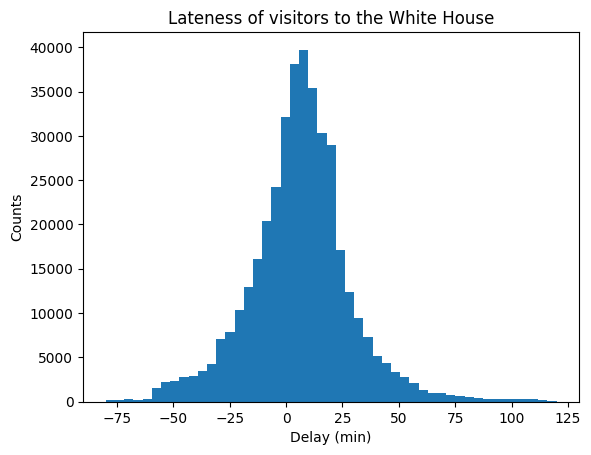

In [32]:
import matplotlib.pyplot as plt
import numpy as np

bins, counts = df.filter(F.col("TOA").isNotNull()).select(
    ((F.col("TOA").cast("long") - F.col("Appointment Start Date").cast("long"))/60).alias("delta")
    ).rdd.flatMap(lambda x: x).histogram(list(np.linspace(-80, +120, 50)))

plt.hist(bins[:-1], bins=bins, weights=counts)
plt.xlabel("Delay (min)")
plt.ylabel("Counts")
plt.title("Lateness of visitors to the White House")

# How long are appointments?

In [33]:
df.select(
    (F.col("Appointment End Date").cast("long") - F.col("Appointment Start Date").cast("long")).alias("delta")
    ).agg(F.avg("delta"), F.max("delta"), F.min("delta")).show()

+------------------+----------+----------+
|        avg(delta)|max(delta)|min(delta)|
+------------------+----------+----------+
|42894.041668810125|     86340|       540|
+------------------+----------+----------+



In [41]:
bins, counts = df.select(
    ((F.col("Appointment End Date").cast("long") - F.col("Appointment Start Date").cast("long")) / 60).alias("delta")
    ).rdd.flatMap(lambda x: x).histogram(list(np.linspace(0, +1200, 100)))

plt.hist(bins[:-1], bins=bins, weights=counts)
plt.xlabel("Duration (min)")
plt.ylabel("Counts")
plt.title("White House Appointment Duration")

# How many people visit the white house each time?

In [42]:
df.select(
    (F.col("Total People"))
    ).agg(F.avg("Total People"), F.max("Total People"), F.min("Total People")).show()

+-----------------+-----------------+-----------------+
|avg(Total People)|max(Total People)|min(Total People)|
+-----------------+-----------------+-----------------+
|174.5766671810964|             5619|                1|
+-----------------+-----------------+-----------------+



Text(0.5, 1.0, 'People per visit')

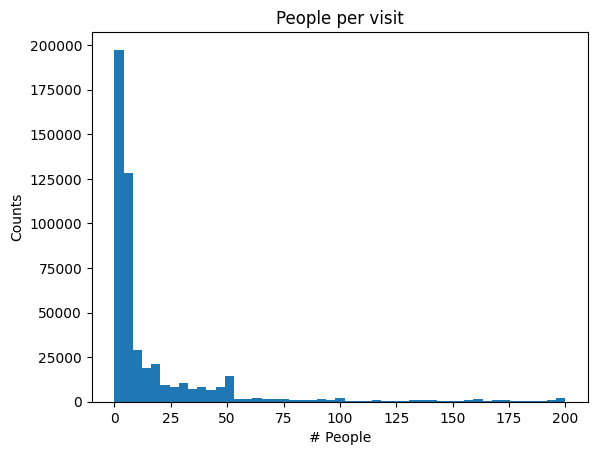

In [39]:
bins, counts = df.select(
    (F.col("Total People"))
    ).rdd.flatMap(lambda x: x).histogram(list(np.linspace(0, 200, 50)))

plt.hist(bins[:-1], bins=bins, weights=counts)
plt.xlabel("# People")
plt.ylabel("Counts")
plt.title("People per visit")

In [7]:
spark.stop()